# 1. Imports

# Hi there!

In [34]:
import pandas as pd # dataframes
from sklearn.preprocessing import RobustScaler # scale to zero mean and unit variance
from sklearn.decomposition import PCA # primary component analysis
from sklearn.ensemble import IsolationForest,RandomForestRegressor
import matplotlib.pyplot as plt # plots
from sklearn import set_config # return pd.DataFrame from transformers
import pickle # move transformers and estimators between notebooks
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
# custom helper functions
from helper_functions import feature_distribution_plot, scree_plot, decision_boundary_plot, imputation_and_accuracy

<hr> 

# 2. Settings

In [35]:
set_config(transform_output='pandas')

<hr> 

# 3. Preprocess the Data Set

## 3.1 General Preprocessing

In [36]:
df = pd.read_csv('./data/hcvdat22_Clustering.csv')

Some basic information on the dataset:

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  615 non-null    int64  
 1   Age         615 non-null    int64  
 2   Sex         615 non-null    object 
 3   ALB         614 non-null    float64
 4   ALP         597 non-null    float64
 5   ALT         614 non-null    float64
 6   AST         615 non-null    float64
 7   BIL         615 non-null    float64
 8   CHE         615 non-null    float64
 9   CHOL        605 non-null    float64
 10  CREA        615 non-null    float64
 11  GGT         615 non-null    float64
 12  PROT        614 non-null    float64
dtypes: float64(10), int64(2), object(1)
memory usage: 62.6+ KB


- there are 615 rows and 13 columns
- 5/13 columns have duplicate values
- we can drop the duplicate index and the categorical 'sex' column

In [38]:
df.drop(columns=['Unnamed: 0', 'Sex'], inplace=True)

Inspecting some rows of the data:

In [39]:
df.head()

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,32,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,32,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,32,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,32,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,32,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


## 3.2 Data Distribution

# TODO:
## Plot anpassen für splate Sex

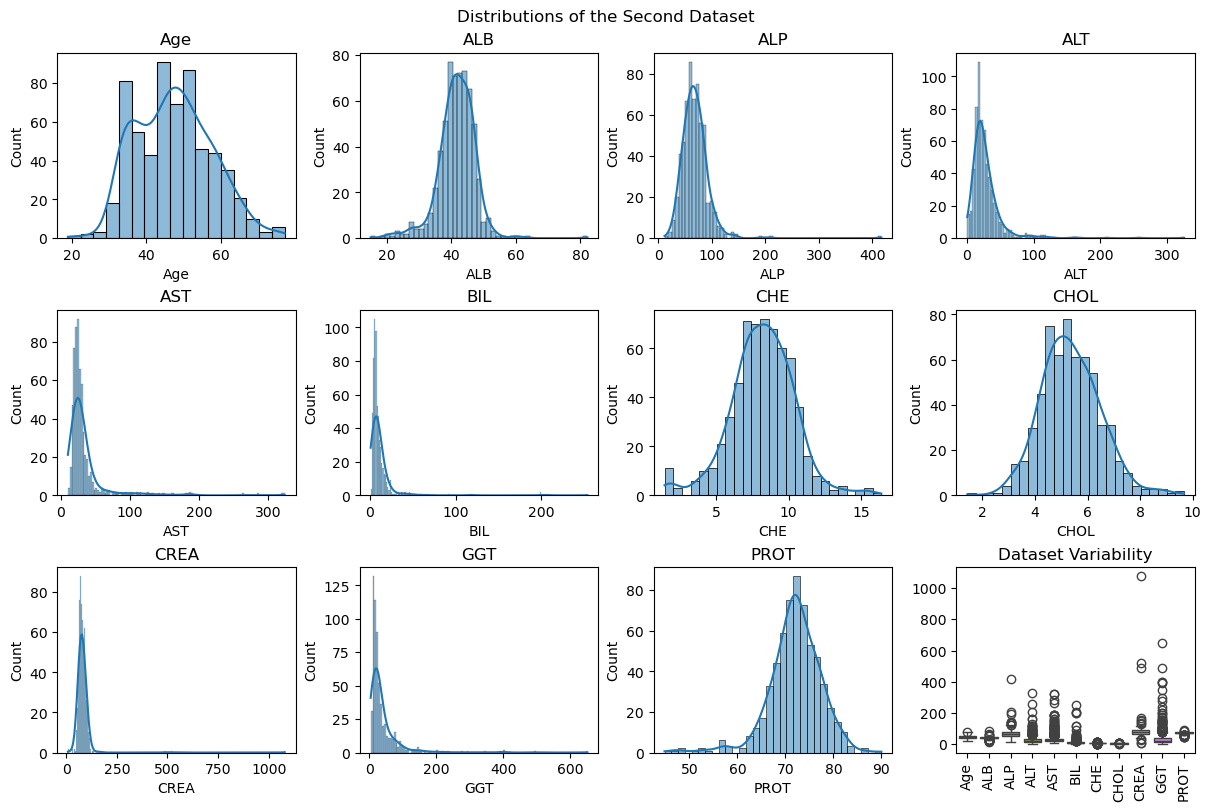

In [40]:
plot_feature_distribution = feature_distribution_plot(df=df, suptitle='Distributions of the Second Dataset')

Except for age, all features mostly seem to follow a gaussian distribution. However, all features contain outliers which are most noticeable for CREA and GGT. These outliers could represent people for medical conditions  not suitable for blood donation, which we aim to identify.

<hr> 

## 4. Impute Missing Values
- Estimate the accuracy of the imputation for each feature

## 4.1 Show and plot the missing values

How many rows with missing values are there?

In [41]:
na_rows = df[df.isna().any(axis=1)]
len(na_rows)

26

Inspect all 26 rows with missing values:

In [42]:
na_rows

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
121,43,48.6,45.0,10.5,40.5,5.3,7.09,NaN,63.0,25.1,70.0
319,32,47.4,52.5,19.1,17.1,4.6,10.19,NaN,63.0,23.0,72.2
329,33,42.4,137.2,14.2,13.1,3.4,8.23,NaN,48.0,25.7,74.4
413,46,42.9,55.1,15.2,29.8,3.6,8.37,NaN,61.0,29.0,71.9
424,48,45.6,107.2,24.4,39.0,13.8,9.77,NaN,88.0,38.0,75.1
433,48,46.8,93.3,10.0,23.2,4.3,12.41,NaN,52.0,23.9,72.4
498,57,48.4,94.4,2.5,39.6,2.3,8.84,NaN,82.0,6.4,76.8
540,38,45.0,56.3,NaN,33.1,7.0,9.58,6.0,77.9,18.9,63.0
541,19,41.0,NaN,87.0,67.0,12.0,7.55,3.9,62.0,65.0,75.0
545,29,49.0,NaN,53.0,39.0,15.0,8.79,3.6,79.0,37.0,90.0


In [61]:
idx_na_rows = na_rows.index


Index([121, 319, 329, 413, 424, 433, 498, 540, 541, 545, 546, 568, 569, 570,
       571, 576, 581, 582, 583, 584, 585, 590, 592, 603, 613, 614],
      dtype='int64')

- rows have up to 3/11 NaN values
- 18/26 instances from ALP are NaN
    - keep them because they're only (18/615) ~ 2 % of the original data
- neither columns nor rows get dropped
- missing values get imputed

Show the NAN values for each column

In [44]:
df_nas = df.isnull()
df_nas_sum = df_nas.sum()
print("Sum of NAs in data:")
print(df_nas_sum)

Sum of NAs in data:
Age      0
ALB      1
ALP     18
ALT      1
AST      0
BIL      0
CHE      0
CHOL    10
CREA     0
GGT      0
PROT     1
dtype: int64


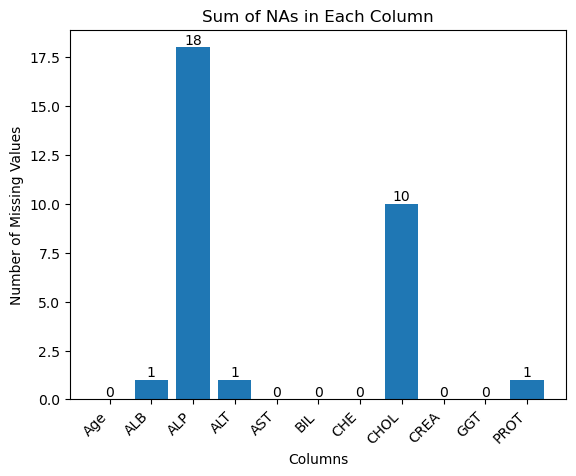

In [45]:
# Plotting the bar chart
fig, ax = plt.subplots()
bars = plt.bar(df_nas_sum.index, df_nas_sum)
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Sum of NAs in Each Column')
plt.xticks(rotation=45, ha='right')  # Rotating x-axis labels for better visibility

# Adding counts on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', color='black')

plt.show()

## 4.2 Now impute the missing values using sklearn imputers

# TODO: Only features which have nan

In [46]:
# Create a DataFrame without NaN values
df_no_nan = df.dropna().copy()

# Split the data into training and test sets
train_data, test_data = train_test_split(df_no_nan, test_size=0.2, random_state=42)

rf_estimator = RandomForestRegressor(n_estimators=10)
knn_estimator = KNeighborsRegressor(n_neighbors=5)

imputer_dict = {
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
    'iterative_rf': IterativeImputer(estimator=rf_estimator),
    'iterative_knn': IterativeImputer(estimator=knn_estimator),
    'knn': KNNImputer(n_neighbors=5, weights='distance')
}

# Call the function with train and test data
accuracy_results = imputation_and_accuracy(train_data, test_data, df_no_nan.columns, imputer_dict)

# Display the accuracy results DataFrame
accuracy_results


,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
mean,0.025424,26.923347,498.483017,480.888634,1429.891963,414.551145,6.568637,1.113107,236.70181,1412.898448,32.533024
median,0.025424,26.829831,493.51161,492.288305,1561.60339,434.737881,6.515908,1.111318,241.26661,1608.90339,32.209492
iterative_rf,0.059322,14.862742,439.926289,339.278016,620.143362,273.247192,3.817531,0.83855,483.058639,1942.577203,22.842781
iterative_knn,0.025424,20.264122,488.380532,419.532092,1069.575905,381.561322,4.845908,1.020859,912.358983,1019.921102,27.742102
knn,0.025424,19.929279,482.067461,463.879963,1077.600778,373.144799,4.826319,1.029418,1021.120161,1097.993762,27.967996


<hr>

# FRAGE: Müssen wir diskutieren welchen imputer wir nehmen und warum

# Kurze Erklärung wäre gut

## 4.3 Perform actual Imputation

In [47]:
iterative_imputer_rf = imputer_dict["iterative_rf"]# TODO: either add indicator or save missing_indicator separately
df_imputed = iterative_imputer_rf.fit_transform(df)

/Users/Anna/anaconda3/envs/anna/lib/python3.12/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Are there any missing values left?

In [48]:
len(df_imputed[df_imputed.isna().any(axis=1)])

0

<hr>

## 5. Scaling
Scale the features to zero mean and unit variance using a robust scaling approach to control for the effect of outliers and different scales:

In [49]:
scaler = RobustScaler() # instantiate scaler
df_scaled = scaler.fit_transform(df_imputed) # fit the scaler create scaled data

Inspect the scaled features:

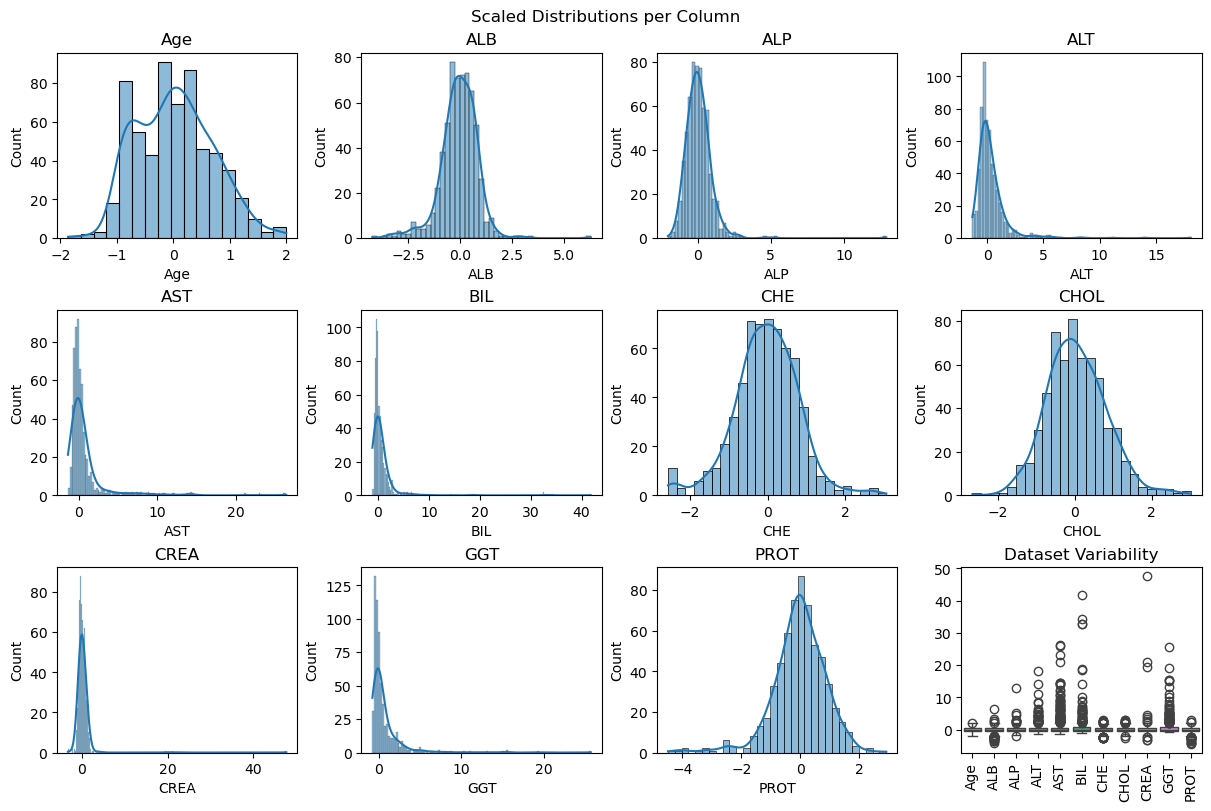

In [50]:
plot_feature_distribution_scaled = feature_distribution_plot(df=df_scaled, suptitle='Scaled Distributions per Column')

The distributions look the same but in the dataset variability plot, we can observe how the scale has narrowed down significantly, making the pca less susceptible to outliers.

# Principal Component Analysis
- Transform the data into the principal components from phase one
- Would it make sense to retrain the PCA for the new data?
    - Yes, since the PCA is dependant on the data's distribution which has changed between phases one and two

## Using the original (old) PCA

In [51]:
# import the pca from phase one
with open('./pickle/pca_phase_one.pkl', 'rb') as file:
    pca_phase_one = pickle.load(file)

In [52]:
df_pca_phase_one = pca_phase_one.transform(df_scaled)

## Training a new PCA

In [53]:
N_COMPONENTS = 11
pca_phase_two = PCA(n_components=N_COMPONENTS)

In [54]:
df_pca_phase_two = pca_phase_two.fit_transform(df_scaled)

## Comparing Principal Components

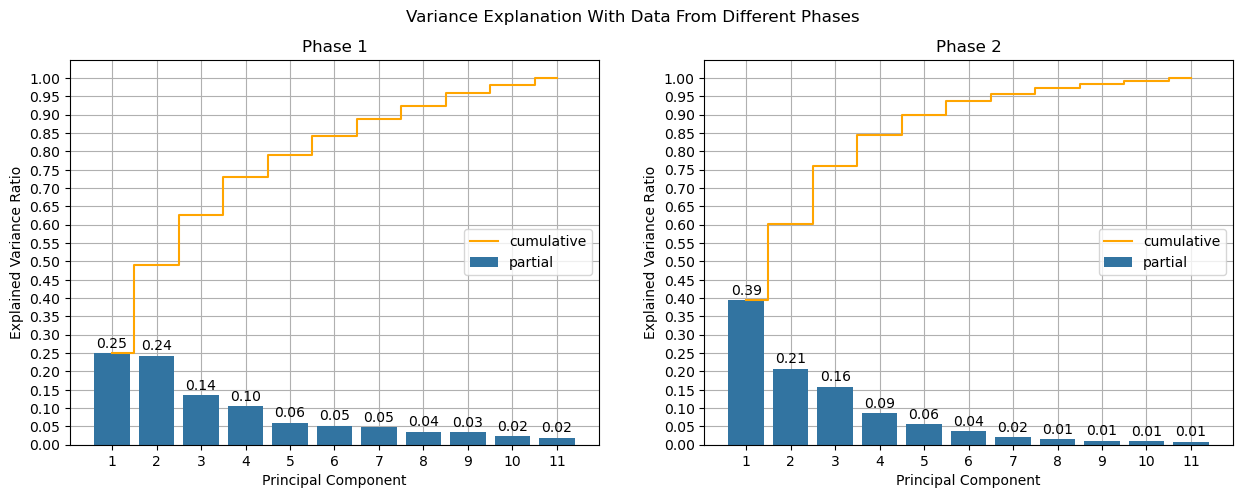

In [55]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

scree_plot(ax1, pca_phase_one, 'Phase 1')
scree_plot(ax2, pca_phase_two, 'Phase 2')

plt.suptitle('Variance Explanation With Data From Different Phases')

plt.show()

# Perform a Cluster Analysis
-Compare and discuss the results of the Anomaly Detection & Cluster Analysis

In [56]:
# import the fitted isolation forest
with open('./pickle/isolation_forest_phase_one.pkl', 'rb') as file:
    isolation_forest_phase_one = pickle.load(file)

In [57]:
first_two_pcs_new = df_pca_phase_two.iloc[:,:2]
predictions = isolation_forest_phase_one.predict(first_two_pcs_new)
df_pca_phase_two['outlier'] = predictions

In [58]:
df_pca_phase_two

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,outlier
0,-1.449380,1.049956,1.075496,-1.131854,-1.120476,0.795013,-1.211316,0.569604,0.852647,-0.163420,-0.291283,1
1,-1.883685,0.137816,-0.347199,-0.375982,-0.182845,-0.488074,0.112374,0.329528,1.238758,-0.753817,-0.892779,1
2,0.130516,-1.575646,-0.047122,-1.077686,0.658046,-1.244335,-0.200533,0.886489,0.487673,-0.414213,0.169864,1
3,0.200459,1.597569,-0.064342,0.205191,0.501139,-0.418110,-1.185273,0.332270,0.341607,-0.533583,0.056612,1
4,-0.831285,0.426727,-0.163836,0.194670,0.246739,0.694242,-0.357787,0.409681,1.243769,-0.057416,-0.146259,1
...,...,...,...,...,...,...,...,...,...,...,...,...
610,17.559799,-9.576840,4.121814,19.320769,-6.866771,-0.867232,4.221321,4.925422,1.275573,0.164126,0.674159,-1
611,1.892763,0.914390,-0.866869,-0.297169,-2.417539,2.580764,0.408594,1.830120,-1.362305,-1.047931,-1.039802,1
612,8.431794,0.769455,-1.373143,-1.806301,-2.008675,0.225096,0.436131,1.625746,-1.813944,-1.432017,-1.090603,-1
613,2.856871,-0.654633,-1.687575,-0.579636,-0.271170,1.544489,-0.696515,0.608251,-0.538597,-0.808292,0.053580,1


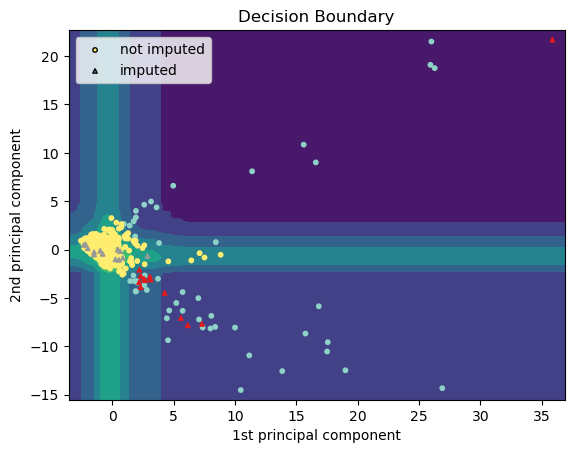

In [59]:
plot_decision_boundary = decision_boundary_plot(df=df_pca_phase_two, estimator=isolation_forest_phase_one, imputed_rows=idx_na_rows)

## TODO: Discussion

# FRAGE: Passt das so mit den Dreiecken udn den Kreisen oder was ist gemeint mit different marker style